In [3]:
import matplotlib.pyplot as plt
from rich import print as rprint
import pywt
from sklearn.decomposition import PCA
import pandas as pd

In [4]:
# ------------------------------------------------------------
# Algorithm: Predict Human Age from Eye Color Intensity
# Source: Lahza et al. (Healthcare, 2023)
# ------------------------------------------------------------

import os
import cv2
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, precision_score, recall_score, f1_score

# === Helper Functions ===

# --- File Handling Utilities ---
def is_folder(path):
    """Check if a given path is a folder."""
    return os.path.isdir(path)


def list_all_images(folder):
    """Return a list of all image file paths from the folder."""
    exts = ('.jpg', '.jpeg', '.png', '.bmp')
    return [os.path.join(folder, f) for f in os.listdir(folder) if f.lower().endswith(exts)]

    
def load_images(source):
    """Load a single image or a sequence of images from path/folder."""
    if is_folder(source):
        return [cv2.imread(f) for f in list_all_images(source)]
    else:
        return [cv2.imread(source)]


def to_grayscale(img):
    """Convert image to grayscale."""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


def apply_filters(img, methods=["gaussian", "median"]):
    """Apply filtering to remove noise."""
    filtered = img.copy()
    if "gaussian" in methods:
        filtered = cv2.GaussianBlur(filtered, (5, 5), 0)
    if "median" in methods:
        filtered = cv2.medianBlur(filtered, 5)
    return filtered


def resize_image(img, size=(227, 227)):
    """Resize image to AlexNet input size."""
    return cv2.resize(img, size)


def enhance_contrast(img):
    """Use histogram equalization to enhance pixel intensity."""
    return cv2.equalizeHist(img)


def apply_wavelet_transform(img):
    """Placeholder for DWT: enhances texture + suppresses noise."""
    # actual DWT would use pywt.dwt2 or similar
    return img


def apply_pca(img):
    """Placeholder PCA step: dimensionality reduction for feature extraction."""
    # In MATLAB, this was for image decorrelation; we just return img here
    return img


def detect_face(img):
    """Detect face using Haar Cascade (Viola–Jones equivalent)."""
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    faces = face_cascade.detectMultiScale(img, 1.3, 5)
    return faces


def detect_eyes(face_region):
    """Detect eyes in the cropped face region."""
    eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_eye.xml")
    eyes = eye_cascade.detectMultiScale(face_region, 1.3, 5)
    return eyes


def crop_to_region(img, region):
    """Crop image according to bounding box coordinates."""
    (x, y, w, h) = region
    return img[y:y+h, x:x+w]


def compute_histogram(img):
    """Compute color histogram of eye region."""
    hist = cv2.calcHist([img.astype(np.float32)], [0], None, [256], [0, 256])
    return hist


def extract_features(histogram, features=["mean", "std", "peaks", "valleys"]):
    """Extract statistical features from histogram."""
    h = histogram.flatten()
    feats = {}
    if "mean" in features:
        feats["mean"] = np.mean(h)
    if "std" in features:
        feats["std"] = np.std(h)
    if "peaks" in features:
        feats["peaks"] = np.argmax(h)
    if "valleys" in features:
        feats["valleys"] = np.argmin(h)
    return np.array(list(feats.values()))


def cnn_predict(features):
    """Placeholder CNN model prediction."""
    # In real use: feed features into trained CNN (AlexNet-based)
    return np.random.uniform(10, 60)  # mock predicted age


def evaluate_performance(true, pred, metrics=["accuracy", "MSE", "MAE", "precision", "recall", "f1"]):
    """Compute evaluation metrics as per paper."""
    from sklearn.metrics import mean_absolute_error, mean_squared_error, precision_score, recall_score, f1_score
    results = {}
    if "MSE" in metrics:
        results["MSE"] = mean_squared_error(true, pred)
    if "MAE" in metrics:
        results["MAE"] = mean_absolute_error(true, pred)
    if "accuracy" in metrics:
        results["accuracy"] = np.mean(np.abs(np.array(true) - np.array(pred)) < 3) * 100  # ±3 years tolerance
    if "precision" in metrics:
        results["precision"] = precision_score(true, pred, average='micro', zero_division=0)
    if "recall" in metrics:
        results["recall"] = recall_score(true, pred, average='micro', zero_division=0)
    if "f1" in metrics:
        results["f1"] = f1_score(true, pred, average='micro', zero_division=0)
    return results


# === Main Algorithm ===

def predict_age_from_eyes(input_source, true_labels=None):
    """
    Full algorithm to predict human chronological age from eye color intensity.
    """
    images = load_images(input_source)
    predicted_ages = []

    for img in images:
        # Step 1: Preprocessing
        gray = to_grayscale(img)
        filtered = apply_filters(gray)
        resized = resize_image(filtered)
        enhanced = enhance_contrast(resized)
        wave = apply_wavelet_transform(enhanced)
        pca_img = apply_pca(wave)

        # Step 2: Face and Eye Detection
        faces = detect_face(pca_img)
        for (x, y, w, h) in faces:
            face_region = pca_img[y:y+h, x:x+w]
            eyes = detect_eyes(face_region)

            for (ex, ey, ew, eh) in eyes:
                eye_img = crop_to_region(face_region, (ex, ey, ew, eh))

                # Step 3: Feature Extraction
                hist = compute_histogram(eye_img)
                features = extract_features(hist)

                # Step 4: CNN-based Prediction
                age = cnn_predict(features)
                predicted_ages.append(age)

    # Step 5: Evaluation (if labels available)
    if true_labels:
        metrics = evaluate_performance(true_labels, predicted_ages)
    else:
        metrics = {}

    return predicted_ages, metrics


# # === Example usage ===
# if __name__ == "__main__":
#     images_path = "dataset/test_images"
#     true_ages = [25, 32, 46, 50, 5]  # example
#     predicted, metrics = predict_age_from_eyes(images_path, true_ages)

#     print("Predicted Ages:", predicted)
#     print("Performance Metrics:", metrics)


In [5]:
# ------------------------------------------------------------
# Algorithm: Human Eye Color Intensity & Age Prediction
# Based on Lahza et al. (Healthcare, 2023)
# ------------------------------------------------------------

def predict_age_from_eyes(input_source):
    """
    input_source: path to an image, a folder of images, or video feed
    output: predicted age(s)
    """

    # Step 1. Read input image(s)
    images = load_images(input_source)

    predicted_ages = []

    for img in images:
        # Step 2. Image Preprocessing
        gray = to_grayscale(img)
        denoised = apply_filters(gray, methods=["gaussian", "median"])
        resized = resize_image(denoised, (227, 227))  # as used in AlexNet
        enhanced = enhance_contrast(resized)
        preprocessed = apply_wavelet_transform(enhanced)
        preprocessed = apply_pca(preprocessed)

        # Step 3. Detect face and eyes (Viola–Jones equivalent)
        face_region = detect_face(preprocessed)
        eye_regions = detect_eyes(face_region)

        for eye in eye_regions:
            cropped_eye = crop_to_region(preprocessed, eye)

            # Step 4. Analyze color intensities
            histogram = compute_histogram(cropped_eye)
            color_features = extract_features(histogram, 
                                features=["mean", "std", "peaks", "valleys"])

            # Step 5. Predict age using CNN
            predicted_age = cnn_model.predict(color_features)
            predicted_ages.append(predicted_age)

    # Step 6. Compute performance metrics
    results = evaluate_performance(true_labels, predicted_ages,
                                   metrics=["accuracy", "MSE", "MAE", 
                                            "precision", "recall", "f1"])

    return predicted_ages, results


In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models
import cv2
import numpy as np

# --- Step 1: Build CNN model (AlexNet-like) ---
def build_cnn(input_shape=(227, 227)):
    model = models.Sequential([
        layers.Conv2D(96, (11, 11), strides=4, activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((3, 3), strides=2),
        layers.Conv2D(256, (5, 5), padding='same', activation='relu'),
        layers.MaxPooling2D((3, 3), strides=2),
        layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((3, 3), strides=2),
        layers.Flatten(),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1)  # regression output (age)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss='mean_squared_error',
                  metrics=['mae'])
    return model


# --- Step 2: Eye extraction (Viola–Jones equivalent) ---
def extract_eye_region(image_path):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_eye.xml")

    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    faces = face_cascade.detectMultiScale(gray)
    for (x, y, w, h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        for (ex, ey, ew, eh) in eyes:
            eye_img = img[y+ey:y+ey+eh, x+ex:x+ex+ew]
            eye_resized = cv2.resize(eye_img, (227, 227))
            return eye_resized
    return None


# # --- Step 3: Example usage ---
# if __name__ == "__main__":
#     cnn_model = build_cnn()

#     image = extract_eye_region("face_sample.jpg")
#     if image is not None:
#         input_data = np.expand_dims(image / 255.0, axis=0)
#         predicted_age = cnn_model.predict(input_data)
#         print("Predicted Age:", float(predicted_age))


2025-11-16 14:02:33.647075: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-16 14:02:33.648510: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-16 14:02:33.672124: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-16 14:02:33.672155: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-16 14:02:33.672171: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [7]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_eye.xml")

In [10]:
image_path = "sub_dir0/25_1_0_20170117140138784.jpg.chip.jpg"
img = cv2.imread(image_path)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
rprint(img.shape, gray.shape)

faces = face_cascade.detectMultiScale(gray)

roi_gray = gray[35:83, 27:162]
eye_resized = cv2.resize(roi_gray, (227, 227))

(200, 200, 3)
(200, 200)

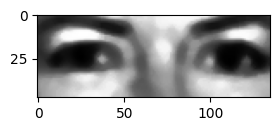

In [11]:
plt.figure(figsize = (3, 3))
plt.imshow(enhance_contrast(apply_filters(roi_gray, 'median')), cmap = "gray")
plt.show()

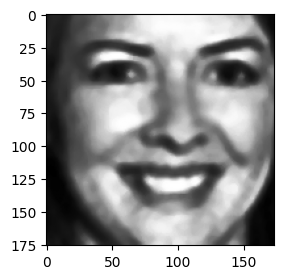

In [19]:
face_cut = gray[15:191, 0:174]
plt.figure(figsize = (3, 3))
plt.imshow(enhance_contrast(apply_filters(face_cut, 'median')), cmap = "gray")
plt.show()

In [21]:
roi_gray

array([[132, 131, 131, ..., 105, 119, 126],
       [130, 130, 128, ...,  97, 107, 116],
       [125, 124, 121, ...,  92, 101, 110],
       ...,
       [157, 160, 163, ..., 173, 174, 173],
       [158, 161, 163, ..., 173, 172, 171],
       [158, 161, 164, ..., 172, 170, 168]], dtype=uint8)

In [22]:
pywt.dwt2(enhance_contrast(apply_filters(roi_gray, 'median')), 'haar')[1][0]

array([[  0.5,   4. ,   6.5, ...,  -0.5,   3. ,   6. ],
       [  7. ,   7.5,   8.5, ...,  -1. ,   1. ,   2. ],
       [  4.5,   7. ,   2. , ..., -13. ,  -4. ,   0. ],
       ...,
       [  3. ,   2. ,   0. , ...,   2. ,   1.5,   3. ],
       [  5.5,   1.5,   0. , ...,   1.5,   1. ,   0. ],
       [  1.5,   0. ,   1. , ...,   0. ,   1.5,   3. ]])

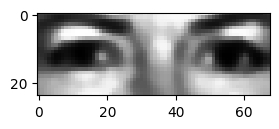

In [23]:
plt.figure(figsize = (3, 3))
plt.imshow(pywt.dwt2(enhance_contrast(apply_filters(roi_gray, 'median')), 'haar')[0], cmap = "gray")
plt.show()

In [24]:
pca = PCA(n_components=8)
fil_img = pywt.dwt2(enhance_contrast(apply_filters(roi_gray, 'median')), 'haar')[0]
trans = pca.fit_transform(fil_img)

In [25]:
fil_img.shape

(24, 68)

In [26]:
pca.inverse_transform(trans).shape

(24, 68)

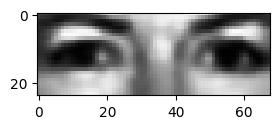

In [27]:
plt.figure(figsize = (3, 3))
plt.imshow(pca.inverse_transform(trans), cmap = "gray")

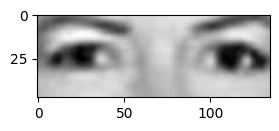

In [28]:
plt.figure(figsize = (3, 3))
plt.imshow(roi_gray, cmap = "gray")

In [29]:
blur_score(img)

NameError: name 'blur_score' is not defined

In [30]:
import cv2

img = cv2.imread(image_path)
saliency = cv2.saliency.StaticSaliencySpectralResidual_create()
(success, saliencyMap) = saliency.computeSaliency(img)

# Convert to visible map
saliencyMap = (saliencyMap * 255).astype("uint8")

# cv2.imshow("Saliency Map", saliencyMap)
# cv2.waitKey(0)


In [9]:
success

True

In [31]:
import torch
from piq import brisque
from PIL import Image

import torchvision.transforms as T

# Load and preprocess image
def is_blurry(image_path):
    image = Image.open(image_path).convert('RGB')
    transform = T.ToTensor()
    image_tensor = transform(image).unsqueeze(0) # Add batch dimension
    
    # Calculate BRISQUE score
    quality_score = brisque(image_tensor, data_range=1.0)
    
    # Lower score = better perceptual quality
    return quality_score.item()

In [32]:
is_blurry(image_path)

56.824462890625

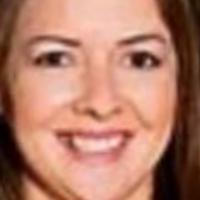

In [34]:
Image.open(image_path)

In [1]:
img = plt.imread("face_age/019/8816.png")
blur_score(img)

NameError: name 'plt' is not defined

In [92]:
# Convert to uint8 if float
if img.dtype != np.uint8:
    if img.max() <= 1.0:
        img = (img * 255).astype(np.uint8)
    else:
        img = img.astype(np.uint8)
cv2.Laplacian(img, cv2.CV_64F).var()

9.531772666388889

In [80]:
import cv2
import numpy as np

def blur_score(img):
    """
    Compute multiple blur metrics (Laplacian, Sobel, FFT) for an image.
    Returns a dictionary of scores and a final blurry decision.
    """
    # Ensure grayscale
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Convert to uint8 if float
    if img.dtype != np.uint8:
        if img.max() <= 1.0:
            img = (img * 255).astype(np.uint8)
        else:
            img = img.astype(np.uint8)
    
    # 1️⃣ Laplacian variance
    lap_var = cv2.Laplacian(img, cv2.CV_64F).var()
    
    # 2️⃣ Sobel (Tenengrad) variance
    gx = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    gy = cv2.Sobel(img, cv2.CV_64F, 0, 1)
    sobel_var = np.sqrt(gx**2 + gy**2).var()
    
    # 3️⃣ FFT high-frequency energy
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = np.abs(fshift)
    h, w = magnitude_spectrum.shape
    center_region = magnitude_spectrum[h//4:3*h//4, w//4:3*w//4]
    fft_energy = np.mean(magnitude_spectrum) - np.mean(center_region)
    
    # Combined normalized score (empirical weighting)
    combined_score = (lap_var / 200) + (sobel_var / 200) + (fft_energy / 1e5)
    
    # Final decision (tune threshold based on dataset)
    is_blur = combined_score < 1.0

    return {
        "laplacian_var": lap_var,
        "sobel_var": sobel_var,
        "fft_energy": fft_energy,
        "combined_score": combined_score,
        "is_blur": bool(is_blur)
    }


In [104]:
def is_blurry(img_path):
    img = plt.imread(img_path)
    """Return True if image is blurry."""
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Convert to uint8 if float
    if img.dtype != np.uint8:
        if img.max() <= 1.0:
            img = (img * 255).astype(np.uint8)
        else:
            img = img.astype(np.uint8)
    cv2.Laplacian(img, cv2.CV_64F).var()
    var = cv2.Laplacian(img, cv2.CV_64F).var()
    return var

In [105]:
is_blurry(img_path = "face_age/019/2784.png")

7.13739264

In [13]:
import os

In [22]:
blur_dict = {}
for folder in ['sub_dir'+str(i) for i in range(5)]:
    for img in os.listdir(folder):
        img_path = folder + "/" + img
        if '.ipynb_checkpoints' in img_path:
            continue
        else:
            blur_dict[img_path] = is_blurry(img_path)
    rprint(f"{folder} -----> completed !!!")

sub_dir0 -----> completed !!!

sub_dir1 -----> completed !!!

sub_dir2 -----> completed !!!

sub_dir3 -----> completed !!!

sub_dir4 -----> completed !!!

In [20]:
blur_dict = {}
for folder in os.listdir("face_age"):
    for img in os.listdir("face_age/" + folder):
        img_path = "face_age/" + folder + "/" + img
        if '.ipynb_checkpoints' in img_path:
            continue
        else:
            blur_dict[img_path] = is_blurry(img_path)
    rprint(f"{folder} -----> completed !!!")

NameError: name 'rprint' is not defined

In [28]:
blur_df = pd.DataFrame(blur_dict, index = ['blur']).T
blur_df.sample(3)

,blur
sub_dir0/1_1_0_20170109191225850.jpg.chip.jpg,43.056274
sub_dir2/20_0_2_20170117193519517.jpg.chip.jpg,41.268677
sub_dir1/26_1_3_20170104232413655.jpg.chip.jpg,65.188751


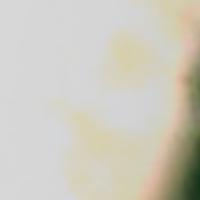

In [49]:
Image.open('sub_dir0/90_0_0_20170111210338948.jpg.chip.jpg')

In [39]:
# blur_df[['blur']].describe(percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

In [47]:
blur_df.query("blur >= 75").sample(5)

,blur
sub_dir1/32_1_3_20170109132040475.jpg.chip.jpg,75.289337
sub_dir4/21_0_3_20170119154213179.jpg.chip.jpg,85.399292
sub_dir0/90_0_0_20170111210338948.jpg.chip.jpg,86.794403
sub_dir1/26_0_3_20170119154215714.jpg.chip.jpg,85.399292
sub_dir4/28_0_1_20170117020012900.jpg.chip.jpg,75.537506


In [36]:
blur_df.shape

(23707, 1)

In [132]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization

# -----------------------------
# 1️⃣  Build AlexNet
# -----------------------------
def build_alexnet(input_shape=(227, 227, 3)):
    model = Sequential([
        Conv2D(96, (11, 11), strides=4, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((3, 3), strides=2),

        Conv2D(256, (5, 5), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D((3, 3), strides=2),

        Conv2D(384, (3, 3), padding='same', activation='relu'),
        Conv2D(384, (3, 3), padding='same', activation='relu'),
        Conv2D(256, (3, 3), padding='same', activation='relu'),
        MaxPooling2D((3, 3), strides=2),

        Flatten(),
        Dense(1024, activation='relu'),
        Dropout(0.5),
        Dense(512, activation='relu'),
        Dropout(0.3),

        Dense(1, activation='linear')  # Regression output
    ])
    return model

# -----------------------------
# 2️⃣  Load Dataset
# -----------------------------
DATA_DIR = "face_age/"  # 👈 path to your folder structure

train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels='inferred',
    label_mode='int',         # folders = ages
    image_size=(227, 227),
    batch_size=32,
    shuffle=True,
    seed=42,
    validation_split=0.2,     # 20% for testing
    subset='training'
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels='inferred',
    label_mode='int',
    image_size=(227, 227),
    batch_size=32,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='validation'
)

# -----------------------------
# 3️⃣  Normalize + Optimize Input Pipeline
# -----------------------------
AUTOTUNE = tf.data.AUTOTUNE

def normalize(x, y):
    x = tf.cast(x, tf.float32) / 255.0
    y = tf.cast(y, tf.float32)  # age as float for regression
    return x, y

train_ds = train_ds.map(normalize).cache().shuffle(1000).prefetch(AUTOTUNE)
test_ds  = test_ds.map(normalize).cache().prefetch(AUTOTUNE)

# -----------------------------
# 4️⃣  Compile Model
# -----------------------------
model = build_alexnet()
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='mae',               # Mean Absolute Error for age regression
    metrics=['mae']
)

# -----------------------------
# 5️⃣  Train Model
# -----------------------------
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=20
)

# -----------------------------
# 6️⃣  Evaluate
# -----------------------------
loss, mae = model.evaluate(test_ds)
print(f"\n✅ Test MAE: {mae:.2f} years")

# -----------------------------
# 7️⃣  Save Model
# -----------------------------
model.save("alexnet_age_predictor.h5")


Found 9783 files belonging to 99 classes.
Using 7827 files for training.
Found 9783 files belonging to 99 classes.
Using 1956 files for validation.
Epoch 1/20
245/245 [==============================] - 290s 1s/step - loss: 15.4414 - mae: 15.4414 - val_loss: 23.9425 - val_mae: 23.9425
Epoch 2/20
245/245 [==============================] - 273s 1s/step - loss: 10.6767 - mae: 10.6767 - val_loss: 18.6408 - val_mae: 18.6408
Epoch 3/20
245/245 [==============================] - 271s 1s/step - loss: 9.2186 - mae: 9.2186 - val_loss: 10.0505 - val_mae: 10.0505
Epoch 4/20
245/245 [==============================] - 276s 1s/step - loss: 8.3703 - mae: 8.3703 - val_loss: 10.0500 - val_mae: 10.0500
Epoch 5/20
245/245 [==============================] - 282s 1s/step - loss: 7.8123 - mae: 7.8123 - val_loss: 17.0774 - val_mae: 17.0774
Epoch 6/20
245/245 [==============================] - 277s 1s/step - loss: 7.2475 - mae: 7.2475 - val_loss: 14.0215 - val_mae: 14.0215
Epoch 7/20
245/245 [==================

/home/prithwijit/programming/python/imp_projects/age_gender_project/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras import mixed_precision

# -----------------------------
# 1️⃣ Enable Mixed Precision (uses Tensor Cores)
# -----------------------------
mixed_precision.set_global_policy('mixed_float16')

# -----------------------------
# 2️⃣ Check GPU availability
# -----------------------------
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ Using GPU: {gpus[0].name}")
else:
    print("⚠️ No GPU detected. Using CPU.")

# -----------------------------
# 3️⃣ Define AlexNet
# -----------------------------
def build_alexnet(input_shape=(227, 227, 3)):
    model = Sequential([
        Conv2D(96, (11, 11), strides=4, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((3, 3), strides=2),

        Conv2D(256, (5, 5), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D((3, 3), strides=2),

        Conv2D(384, (3, 3), padding='same', activation='relu'),
        Conv2D(384, (3, 3), padding='same', activation='relu'),
        Conv2D(256, (3, 3), padding='same', activation='relu'),
        MaxPooling2D((3, 3), strides=2),

        Flatten(),
        Dense(1024, activation='relu'),
        Dropout(0.5),
        Dense(512, activation='relu'),
        Dropout(0.3),
        Dense(1, dtype='float32')  # ensure output stays float32
    ])
    return model

# -----------------------------
# 4️⃣ Load Dataset
# -----------------------------
DATA_DIR = "face_age/"

train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels='inferred',
    label_mode='int',
    image_size=(227, 227),
    batch_size=64,            # Larger batch size = better GPU utilization
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='training'
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels='inferred',
    label_mode='int',
    image_size=(227, 227),
    batch_size=64,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='validation'
)

# -----------------------------
# 5️⃣ Normalize + Prefetch
# -----------------------------
AUTOTUNE = tf.data.AUTOTUNE

def normalize(x, y):
    x = tf.cast(x, tf.float32) / 255.0
    y = tf.cast(y, tf.float32)
    return x, y

train_ds = train_ds.map(normalize, num_parallel_calls=AUTOTUNE).cache().shuffle(1000).prefetch(AUTOTUNE)
test_ds  = test_ds.map(normalize, num_parallel_calls=AUTOTUNE).cache().prefetch(AUTOTUNE)

# -----------------------------
# 6️⃣ Compile Model
# -----------------------------
model = build_alexnet()
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='mae',
    metrics=['mae']
)

# -----------------------------
# 7️⃣ Train with GPU
# -----------------------------
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        validation_data=test_ds,
        epochs=20
    )

# -----------------------------
# 8️⃣ Evaluate
# -----------------------------
loss, mae = model.evaluate(test_ds)
print(f"\n✅ Test MAE: {mae:.2f} years")

# -----------------------------
# 9️⃣ Save Model
# -----------------------------
model.save("alexnet_age_predictor_cuda.h5")


In [131]:
blur_df['laplace_blur'].describe(percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).to_frame().T

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
laplace_blur,9778.0,87.748706,150.28571,4.018798,7.839236,11.309476,14.404677,22.762513,41.370718,92.018241,202.301785,313.668136,633.484299,4731.592978


<Axes: ylabel='Frequency'>

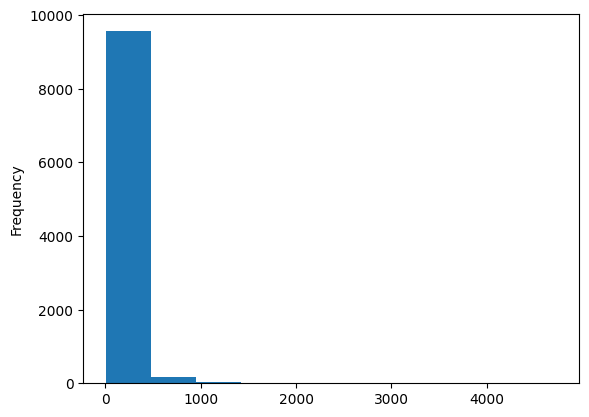

In [126]:
blur_df['laplace_blur'].plot(kind = 'hist')

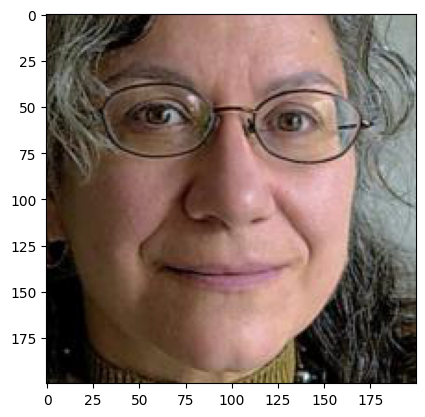

In [129]:
plt.imshow(plt.imread("face_age/063/9146.png"))

In [79]:
np.hstack(compute_histogram(pca.inverse_transform(trans)))

array([ 2.,  2.,  4.,  1.,  7.,  5.,  1.,  3.,  1.,  5.,  2., 10.,  2.,
        5.,  2.,  3.,  2.,  3.,  0.,  6.,  3.,  2.,  1.,  2.,  2.,  3.,
        3.,  5.,  3.,  3.,  3.,  3.,  3.,  5.,  2.,  3.,  1.,  2.,  0.,
        6.,  2.,  0.,  2.,  5.,  2.,  6.,  2.,  2.,  1.,  2.,  5.,  2.,
        4.,  3.,  0.,  3.,  3.,  3.,  3.,  3.,  1.,  6.,  4.,  5.,  8.,
        2.,  1.,  1.,  6.,  1.,  1.,  3.,  4.,  6.,  2.,  2.,  2.,  2.,
        2.,  6.,  1.,  8.,  3.,  5.,  3.,  5.,  1.,  1.,  8.,  5.,  6.,
        6.,  2.,  3.,  3.,  5.,  3.,  4.,  3.,  1.,  4.,  2.,  3.,  5.,
        3.,  3.,  6.,  1.,  4.,  8.,  1.,  2.,  5.,  7.,  3.,  3.,  2.,
        3.,  4.,  2.,  5.,  5.,  0.,  0.,  2.,  3.,  2.,  2.,  6.,  2.,
        2.,  4.,  4.,  1.,  5.,  4.,  0.,  0.,  0.,  2.,  2.,  1.,  2.,
        3.,  2.,  2.,  1.,  1.,  0.,  7.,  1.,  5.,  2.,  1.,  4.,  1.,
        0.,  4.,  3.,  2.,  2.,  0.,  2.,  2.,  5.,  1.,  3.,  3.,  4.,
        4.,  4.,  3.,  3.,  1.,  3.,  1.,  3.,  6.,  2.,  6.,  3

In [67]:
extract_features(compute_histogram(fil_img))

array([ 3.1640625 ,  1.79746938, 94.        ,  0.        ])

In [56]:
fil_img

array([[144.5, 140. , 131.5, ...,  76.5,  95. , 112. ],
       [126. , 114.5,  98.5, ...,  79. ,  84. ,  88. ],
       [103.5,  84. ,  71. , ..., 108. ,  94. ,  90. ],
       ...,
       [296. , 314. , 324. , ..., 372. , 364.5, 363. ],
       [282.5, 310.5, 326. , ..., 364.5, 359. , 356. ],
       [271.5, 309. , 325. , ..., 363. , 351.5, 347. ]])

In [88]:
list(eyes[1][:2]) + [sum([eyes[0][0], eyes[0][2]]), sum([eyes[0][1], eyes[0][3]])]

[7, 32, 142, 80]

[[ 20   3 166 166]]

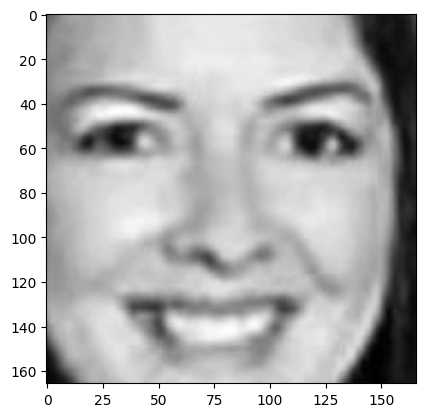

[[96 34 46 46]
 [ 7 32 48 48]]


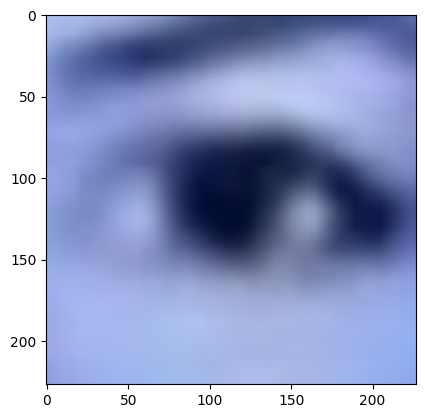

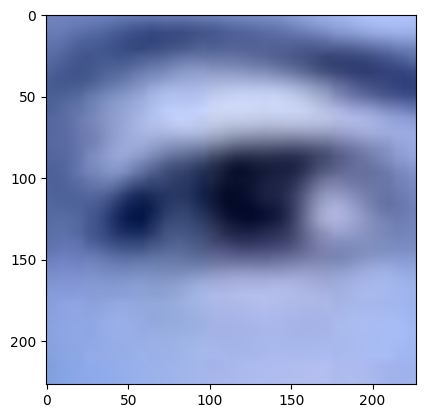

In [80]:
for (x, y, w, h) in faces:
    rprint(faces)
    roi_gray = gray[y:y+h, x:x+w]
    display(plt.imshow(roi_gray, cmap = "gray"))
    plt.show()
    eyes = eye_cascade.detectMultiScale(roi_gray)
    eyes_position = eyes[:2])
    display(plt.imshow(eyes
    # print(eyes)
    # for (ex, ey, ew, eh) in eyes:
    #     eye_img = img[y+ey:y+ey+eh, x+ex:x+ex+ew]
    #     eye_resized = cv2.resize(eye_img, (227, 227))
    #     display(plt.imshow(eye_resized, cmap = "gray"))
    #     plt.show()